# Ensemble
This notebook contains notes and tutorials from all over the internet, which i didn't cite.


### [1.Voting and Averaging](#t1.0)
**Voting**
- Combination: mode (majority)
- Classification
- Heterogeneous ensemble method
**Averaging**
- Combination: mean (average)
- Classification and Regression
- Heterogeneous ensemble method 

**Good Choices when you:**
- Have built multple different models
- Are not sure which is the best
- Want to improve the overall performance

### [2.Bagging](#t2.0)
**Weak estimator**
- Performs just better than random guessing
- Light model and fast model
- Base for homogenous ensemble methods

**Bagging (Bootstrap Aggregating)**
- Random subsamples with replacement
- Large amount of 'weak' estimators
- Aggregated by Voting or Averaging
- Homogeneous ensemble method

**Good Choices when you:**
- Want to reduce variance
- Need to avoid overfitting
- Need more stability and robustness<br>
 *Bagging is computationally expensive*
 

### [3.Boosting](#t3.0)
**Gradual learning**
- Homogeneous ensemble method type
- Based on iterative learning
- Sequential model building

**Boosting algorithms**
- AdaBoost
- Gradient Boosting
    - XGBoost
    - LightGBM
    - CatBoost
    

**Good Choices when you:**
- Have complex problems
- Need to apply parallel processing or distributed computing
- Have big datasets or high-dimensional categorical features

### [4. Stacking](#t4.0)
**Stacking**
- Combination: meta-estimator (model)
- Classification and Regression
- Heterogeneous ensemble method

**Implementation**
- From scratch using pandas and sklearn
- Using the existing MLxtend library
- Have tried Voting/ Averaging but results are not as expected
- Have built models which perform well in different cases

<img src="BoostingSummary.JPG">

#### Predicting the rating of an app

In [73]:
import pandas as pd
import numpy as np
from scipy import stats
import re
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_absolute_error, f1_score, accuracy_score, confusion_matrix, mean_squared_error, roc_curve, auc
from sklearn.ensemble import VotingClassifier, BaggingClassifier, AdaBoostRegressor, AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.naive_bayes import GaussianNB
from mlxtend.classifier import StackingClassifier, StackingCVClassifier
from mlxtend.regressor import StackingRegressor
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools
from sklearn.pipeline import make_pipeline
from mlxtend.feature_selection import ColumnSelector
from sklearn.multiclass import OneVsRestClassifier

import warnings
from sklearn import datasets
import xgboost as xgb
import matplotlib.pyplot as plt
import lightgbm as lgb
warnings.filterwarnings('ignore')


In [2]:
ratings = pd.read_csv('googleplaystore.CSV')
features = ['Reviews', 'Size', 'Installs', 'Type', 'Price', 'Content Rating']
ratings.dropna(inplace = True)
X = ratings[features]
y = ratings.loc[:, ratings.columns == 'Rating']

In [3]:
def value_to_float(x):
    if type(x) == float or type(x) == int:
        return x
    if 'K' in x:
        if len(x) > 1:
            return float(x.replace('K', '')) * 1000
        return 1000.0
    if 'M' in x:
        if len(x) > 1:
            return float(x.replace('M', '')) * 1000000
        return 1000000.0
    if 'B' in x:
        return float(x.replace('B', '')) * 1000000000
    return 0.0

In [4]:
X['Size'] = X.loc[:,'Size'].apply(value_to_float)
X['Installs'] = X['Installs'].map(lambda x: re.sub(r'[\,\+]','',x)).astype('float64')
X['Price'] = X['Price'].map(lambda x: re.sub(r'[\$]','',x)).astype('float64')
X['Reviews']= X.Reviews.astype('float64')

In [5]:
Type_mapping = {
    'Free':0,
    'Paid':1
}

Content_mapping = {
    'Everyone':0,
    'Teen':13,
    'Mature 17+':17,
    'Everyone 10+':10,
    'Adults only 18+':18,
    'Unrated':1
}
X['Type'] = X['Type'].map(Type_mapping)
X['Content Rating'] = X['Content Rating'].map(Content_mapping)

In [6]:
# Split into train (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

# Instantiate the regressor
reg_dt = DecisionTreeRegressor(min_samples_leaf=3, min_samples_split=9, random_state=500)

# Fit to the training set
reg_dt.fit(X_train, y_train)

# Evaluate the performance of the model on the test set
y_pred = reg_dt.predict(X_test)
print('MAE: {:.3f}'.format(mean_absolute_error(y_test, y_pred)))

MAE: 0.367


<a id="t1.0"></a>
## Voting & Averaging
**Choosing the best model**

In [7]:
pokemon = pd.read_csv('pokemon.csv')

In [8]:
features = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Generation']
X = pokemon[features]
y = pokemon.loc[:,pokemon.columns == 'Legendary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
clf_lr = LogisticRegression()
clf_dt = DecisionTreeRegressor()
clf_knn = KNeighborsClassifier(5)

clf_lr.fit(X_train, y_train.values.ravel())
clf_dt.fit(X_train, y_train.values.ravel())
clf_knn.fit(X_train, y_train.values.ravel())

# Predict the labels of the test set
pred_lr = clf_lr.predict(X_test)
pred_dt = clf_dt.predict(X_test)
pred_knn = clf_knn.predict(X_test)

# Evaluate the performance of each model
score_lr = f1_score(y_test, pred_lr)
score_dt = f1_score(y_test, pred_dt)
score_knn = f1_score(y_test, pred_knn)

# Print the scores
print(score_lr)
print(score_dt)
print(score_knn)

0.608695652173913
0.608695652173913
0.47619047619047616


#### Assembling your first ensemble

In [9]:
# Instantiate the individual models
clf_knn = KNeighborsClassifier(n_neighbors=5)
clf_lr = LogisticRegression(class_weight='balanced')
clf_dt = DecisionTreeClassifier(min_samples_leaf=3, min_samples_split=9, random_state=500)

# Create and fit the voting classifier HARD VOTE
clf_vote = VotingClassifier(
    estimators=[('knn', clf_knn), ('lr', clf_lr), ('dt', clf_dt)]
)
clf_vote.fit(X_train, y_train.values.ravel())

VotingClassifier(estimators=[('knn',
                              KNeighborsClassifier(algorithm='auto',
                                                   leaf_size=30,
                                                   metric='minkowski',
                                                   metric_params=None,
                                                   n_jobs=None, n_neighbors=5,
                                                   p=2, weights='uniform')),
                             ('lr',
                              LogisticRegression(C=1.0, class_weight='balanced',
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2'...
                              Decision

#### Evaluate your ensemble

In [10]:
# Calculate the predictions using the voting classifier
pred_vote = clf_vote.predict(X_test)

# Calculate the F1-Score of the voting classifier
score_vote = f1_score(y_test, pred_vote)
print('F1-Score: {:.3f}'.format(score_vote))

# # Calculate the classification report
# report = classification_report(y_test, pred_vote)
# print(report)

F1-Score: 0.583


#### Averaging
Let's now build an ensemble model using the averaging technique.

In [11]:
got = pd.read_csv('character-predictions_pose.csv')

In [12]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [13]:
missing_values_table(got)

Your selected dataframe has 30 columns.
There are 14 columns that have missing values.


,Missing Values,% of Total Values
mother,1925,98.9
isAliveMother,1925,98.9
heir,1923,98.8
isAliveHeir,1923,98.8
father,1920,98.7
isAliveFather,1920,98.7
spouse,1670,85.8
isAliveSpouse,1670,85.8
dateOfBirth,1513,77.7
age,1513,77.7


In [14]:
got.age = got.age.fillna(got.age.mean())
got[got['age'] < 0] = 0
got = got.fillna(0)

features = ['male', 'book1', 'book2', 'book3', 'book4', 'book5', 'isAliveMother', 'isAliveFather', 'isAliveHeir', 'isAliveSpouse', 'isMarried', 'isNoble', 'age', 'numDeadRelations', 'boolDeadRelations',
       'isPopular', 'popularity']
X = got[features]
y = got.loc[:,got.columns == 'isAlive']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [16]:
# Build the individual models
clf_lr = LogisticRegression(class_weight='balanced')
clf_dt = DecisionTreeClassifier(min_samples_leaf=3, min_samples_split=9, random_state=500)
clf_svm = SVC(probability=True, class_weight='balanced', random_state=500)

# List of (string, estimator) tuples
estimators = [('lr',clf_lr),('dt',clf_dt),('svm',clf_svm)]

# Build and fit an averaging classifier
clf_avg = VotingClassifier(estimators, voting='soft')
clf_avg.fit(X_train, y_train.values.ravel())

# Evaluate model performance
acc_avg = accuracy_score(y_test,  clf_avg.predict(X_test))
print('Accuracy: {:.2f}'.format(acc_avg))

Accuracy: 0.96


#### Soft vs Hard voting

In [17]:
# List of (string, estimator) tuples
estimators = [('dt',clf_dt),('lr',clf_lr),('knn',clf_knn)]

# Build and fit a voting classifier
clf_vote = VotingClassifier(estimators,voting='hard')
clf_vote.fit(X_train, y_train.values.ravel())

# Build and fit an averaging classifier
clf_avg = VotingClassifier(estimators,voting='soft')
clf_avg.fit(X_train, y_train.values.ravel())

# Evaluate the performance of both models
acc_vote = accuracy_score(y_test, clf_vote.predict(X_test))
acc_avg = accuracy_score(y_test,  clf_avg.predict(X_test))
print('Voting: {:.2f}, Averaging: {:.2f}'.format(acc_vote, acc_avg))

Voting: 0.96, Averaging: 0.95


<a id="t2.0"></a>
## Bagging
#### The strength of weak models
 Building multiple models (typically of the same type) from different subsamples of the training dataset.The samples below will first go through the manual way before showing the Sklearn way. The final output prediction is averaged across the predictions of all of the sub-models.

In [18]:
features = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Generation']
X = pokemon[features]
y = pokemon.loc[:,pokemon.columns == 'Legendary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
# Build unrestricted decision tree
clf = DecisionTreeClassifier(min_samples_leaf=3, min_samples_split=9, random_state=500)
clf.fit(X_train, y_train)

# Predict the labels
pred = clf.predict(X_test)

# Print the confusion matrix
cm = confusion_matrix(y_test, pred)
print('Confusion matrix:\n', cm)

# Print the F1 score
score = f1_score(y_test, pred)
print('F1-Score: {:.3f}'.format(score))

Confusion matrix:
 [[143   7]
 [  3   7]]
F1-Score: 0.583


In [19]:
# Build restricted decision tree
clf = DecisionTreeClassifier(max_depth=4, max_features=2, random_state=500)
clf.fit(X_train, y_train)

# Predict the labels
pred = clf.predict(X_test)

# Print the confusion matrix
cm = confusion_matrix(y_test, pred)
print('Confusion matrix:\n', cm)

# Print the F1 score
score = f1_score(y_test, pred)
print('F1-Score: {:.3f}'.format(score))

# Notice how the restricted decision tree performs worse, and is only slightly better than random guessing.
#Model A is a fine-tuned decision tree, with a decent performance on its own. Model B is 'weak', restricted in height and with performance just above 50%.

Confusion matrix:
 [[146   4]
 [  5   5]]
F1-Score: 0.526


#### Bootstrap aggregating
Training with bootstrapping

Let's now build a "weak" decision tree classifier and train it on a sample of the training set drawn with replacement.

In [20]:
# Take a sample with replacement
X_train_sample = X_train.sample(frac=1.0, replace=True, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]

# Build a "weak" Decision Tree classifier
clf = DecisionTreeClassifier(max_depth=4, max_features=2, random_state=500)

# Fit the model to the training sample
clf.fit(X_train_sample, y_train_sample)

# This represents one iteration of a bagging ensemble.

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=2, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=500, splitter='best')

#### A first attempt at bagging
You've seen what happens in a single iteration of a bagging ensemble. Now let's build a custom bagging model!

In [21]:
def build_decision_tree(X_train, y_train, random_state=None):
    
    # Take a sample with replacement
    X_train_sample = X_train.sample(frac=1.0, replace=True, random_state=random_state)
    y_train_sample = y_train.loc[X_train_sample.index]
    # Build a "weak" Decision Tree classifier
    clf = DecisionTreeClassifier(max_depth=4, max_features=2, random_state=500)
    # Fit the model on the training sample
    clf.fit(X_train_sample, y_train_sample)
    
    return clf

def predict_voting(classifiers, X):
    
    # Make the individual predictions
    pred_list = [clf.predict(X) for clf in classifiers]
    # Combine the predictions using "Voting"\n\t
    pred_vote = []
    for i in range(X.shape[0]):
        individual_preds = np.array([pred[i] for pred in pred_list])
        combined_pred = stats.mode(individual_preds)[0][0]
        pred_vote.insert(i, combined_pred)
    return pred_vote

In [22]:
# Build the list of individual models
clf_list = []
for i in range(21):
    clf_list.append(build_decision_tree(X_train, y_train, random_state=i))

# Predict on the test set
pred = predict_voting(clf_list,X_test)

# Print the F1 score
print('F1 score: {:.3f}'.format(f1_score(y_test, pred)))

F1 score: 0.556


#### Bagging: the scikit-learn way

In [23]:
# Instantiate the base model
clf_dt = DecisionTreeClassifier(max_depth=4)

# Build and train the Bagging classifier
clf_bag = BaggingClassifier(base_estimator = clf_dt,n_estimators = 21,random_state=500)
clf_bag.fit(X_train, y_train)

# Predict the labels of the test set
pred = clf_bag.predict(X_test)

# Show the F1-score
print('F1-Score: {:.3f}'.format(f1_score(y_test, pred)))

F1-Score: 0.667


#### Checking the out-of-bag score

In [24]:
# Build and train the bagging classifier
clf_bag = BaggingClassifier(base_estimator = clf_dt,n_estimators = 21,oob_score = True,random_state=500)
clf_bag.fit(X_train, y_train)

# Print the out-of-bag score
print('OOB-Score: {:.3f}'.format(clf_bag.oob_score_))

# Evaluate the performance on the test set to compare
pred = clf_bag.predict(X_test)
print('Accuracy: {:.3f}'.format(accuracy_score(y_test, pred)))

OOB-Score: 0.933
Accuracy: 0.963


#### Bagging parameters: tips and tricks
- `base_estimator`
- `n_estimators`
- `oob_score`
    - `est_bag.oob_score_`
- `max_samples`: the number of samples to draw for each estimator
- `max_features`: the number of features to draw for each estimator
    - classification ~ sqrt(number of features)
    - regression ~ number of features / 3
- `bootstrap`: whether samples are drawn with replacement
    - true --> max_samples = 1.0
    - False --> max_samples < 1.0

In [25]:
secom = pd.read_csv('uci-secom.csv')
secom.head()

,Time,0,1,2,3,4,5,6,7,8,...,581,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1


In [26]:
features = ['Time','Pass/Fail']
X = secom.loc[:, ~secom.columns.isin(features)]
y = secom.loc[:, secom.columns == 'Pass/Fail']

# quick clean up
X = X.apply(lambda x: x.fillna(x.mean()),axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

#As the target has a high class imbalance, use a "balanced" logistic regression as the base estimator here.
# Build a balanced logistic regression
clf_lr = LogisticRegression(class_weight='balanced')

# Build and fit a bagging classifier
clf_bag = BaggingClassifier(clf_lr, oob_score=True, max_features=10, random_state=500)
clf_bag.fit(X_train, y_train)

# Evaluate the accuracy on the test set and show the out-of-bag score
pred = clf_bag.predict(X_test)
print('Accuracy:  {:.2f}'.format(accuracy_score(y_test, pred)))
print('OOB-Score: {:.2f}'.format(clf_bag.oob_score_))

# Print the confusion matrix
print(confusion_matrix(y_test, pred))

Accuracy:  0.65
OOB-Score: 0.56
[[192  98]
 [ 13  11]]


#### Tuning bagging hyperparameters

While you can easily build a bagging classifier using the default parameters, it is highly recommended that you tune these in order to achieve optimal performance. Ideally, these should be optimized using K-fold cross-validation.

In [27]:
# Build a balanced logistic regression
clf_base = LogisticRegression(class_weight='balanced', random_state=42)

# Build and fit a bagging classifier with custom parameters
clf_bag = BaggingClassifier(clf_base, n_estimators=500, max_features=10, max_samples=0.65, bootstrap=False, random_state=500)
clf_bag.fit(X_train, y_train.values.ravel())

# Calculate predictions and evaluate the accuracy on the test set
y_pred = clf_bag.predict(X_test)
print('Accuracy:  {:.2f}'.format(accuracy_score(y_test, y_pred)))


Accuracy:  0.79


<a id="t3.0"></a>
## Boosting
#### Gradual learning

**Collective Learning**
- Principle: wisdom of the crowd
- independent estimators
- Learning the same task for the same goal 
- Parallel building

**Gradual Learning**
- Principal: iterative learning
- Dependent estimators (takes advantage of the previous learner)

1. First attempt (initial model)
2. Feedback (model evaluation)
3. Correct errors (subsequent model)


#### Fitting to noise
**White noise**
- Uncorrelated errors
- Unbiased errors and with constant variance
**Improvement tolerance**
- If Performance difference < improvement threshold:
- Stop training

#### AdaBoost Properties (Adaptive boosting)
Adaboost helps you combine multiple “weak classifiers” into a single “strong classifier”. The most suited and therefore most common algorithm used with AdaBoost are decision trees with one level. Because these trees are so short and only contain one decision for classification, they are often called decision stumps. Weak models are added sequentially, trained using the weighted training data. The process continues until a pre-set number of weak learners have been created (a user parameter) or no further improvement can be made on the training dataset.

1. Initially, Adaboost selects a training subset randomly.
2. It iteratively trains the AdaBoost machine learning model by selecting the training set based on the accurate prediction of the last training.
3. It assigns the higher weight to wrong classified observations so that in the next iteration these observations will get the high probability for classification.
4. Also, It assigns the weight to the trained classifier in each iteration according to the accuracy of the classifier. The more accurate classifier will get high weight.
5. This process iterate until the complete training data fits without any error or until reached to the specified maximum number of estimators.
6. To classify, perform a "vote" across all of the learning algorithms you built.

<img src="AdaBoost.JPG">

**Parameters for AdaBoostClassifier**
- `base_estimator`
    - Default: DecisionTree (max depth = 1)
- `n_estimators`
    - Default: 50
- `learning_rate`
    - Default:1.0
    - trade off between `n_estimators` and `learning_rate`


**Cons**
AdaBoost is sensitive to noise data. It is highly affected by outliers because it tries to fit each point perfectly. AdaBoost is slower compared to XGBoost.

In [28]:
iris = datasets.load_iris()
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

abc = AdaBoostClassifier(n_estimators=50, learning_rate=1)
model = abc.fit(X_train,y_train)

y_pred = model.predict(X_test)
print("Accuracy:",accuracy_score(y_test, y_pred))

Accuracy: 0.8888888888888888


For further evaluation, you can also create a model using different Base Estimators.

In [29]:
svc=SVC(probability=True, kernel = 'linear')
abc = AdaBoostClassifier(n_estimators=50, base_estimator=svc, learning_rate=1)

model = abc.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:",accuracy_score(y_test, y_pred))

Accuracy: 0.9333333333333333


#### Gradient Boosting machine

1. iniial model (weak estimator)
2. New model fits to residuals
3. New additiv model
4. Repeat n times or untill error is small enough
5. Final *additive* model

Residuals = Negative Gradient

Gradient Boosting Algo
- Extreme Gradient Boosting (XGBoost)
- Light Gradient Boosting Machine (LightGBM)
- Categorical Boosting (CatBoost)

**Extreme gradient boosting (XGBoost)**<br>
Boosting is a sequential technique which works on the principle of an ensemble. It combines a set of weak learners and delivers improved prediction accuracy. At any instant t, the model outcomes are weighed based on the outcomes of previous instant t-1. The outcomes predicted correctly are given a lower weight and the ones miss-classified are weighted higher. Note that a weak learner is one which is slightly better than random guessing. For example, a decision tree whose predictions are slightly better than 50%.

To begin with, you should know about the default base learners of XGBoost: tree ensembles. The tree ensemble model is a set of classification and regression trees (CART). Trees are grown one after another ,and attempts to reduce the misclassification rate are made in subsequent iterations.

<img src="xgboost.JPG">

- Optimized for distributed computing
- Parallel training by nature
- Scalable, portable, and accurate

**Parameters**<br>
`learning_rate`: step size shrinkage used to prevent overfitting. Range is [0,1]

`max_depth`: determines how deeply each tree is allowed to grow during any boosting round

`subsample`: percentage of samples used per tree. Low value can lead to underfitting

`colsample_bytree`:percentage of features used per tree. High value can lead to overfitting

`n_estimators`:number of trees you want to build
`objective`: determines the loss function to be used like `reg:linear` for regression problems, `reg:logistic` for classification problems with only decision, `binary:logistic` for classification problems with probability.

Penalization: `gamma`,`alpha`,`lambda`


**Light gradient boosting machine (LGBM)**<br>
Light GBM grows tree vertically while other algorithm grows trees horizontally meaning that Light GBM grows tree leaf-wise while other algorithm grows level-wise. It will choose the leaf with max delta loss to grow. When growing the same leaf, Leaf-wise algorithm can reduce more loss than a level-wise algorithm

<img src="lgbm.JPG">


Light GBM can handle the large size of data and takes lower memory to run. Another reason of why Light GBM is popular is because it focuses on accuracy of results. LGBM also supports GPU learning and thus data scientists are widely using LGBM for data science application development.Light GBM is sensitive to overfitting and can easily overfit small data (use if dataset is over 10K.

- Faster training and more efficient
- Lighter in terms of space
- Optimized for parallel and GPU processing 
- Useful for problems with big datasets and constraints of speed or memory

**LGBM Parameters**<br>
`max_depth`: This parameter is used to handle model overfitting. Any time you feel that your model is overfitted, my first advice will be to lower max_depth.

`min_data_in_leaf`: The default value is 20, optimum value. It is also used to deal over fitting

`feature_fraction`: Used when your boosting is random forest. 0.8 feature fraction means LightGBM will select 80% of parameters randomly in each iteration for building trees

`bagging_fraction`: specifies the fraction of data to be used for each iteration and is generally used to speed up the training and avoid overfitting.

`early_stopping_round`: This parameter can help you speed up your analysis. Model will stop training if one metric of one validation data doesn’t improve in last early_stopping_round rounds. This will reduce excessive iterations.

`lambda`: lambda specifies regularization. Typical value ranges from 0 to 1

`min_gain_to_split`: This parameter will describe the minimum gain to make a split. It can used to control number of useful splits in tree.


**Core Parameters LGBM**<br>
`regression`: for regression<br>
`binary`: for binary classification<br>
`multiclass`: for multiclass classification problem<br>

**boosting**:<br>
`gbdt`: traditional Gradient Boosting Decision Tree<br>
`rf`: random forest<br>
`dart`: Dropouts meet Multiple Additive Regression Trees<br>
`goss`: Gradient-based One-Side Sampling<br>
`learning_rate`: This determines the impact of each tree on the final outcome. GBM works by starting with an initial estimate which is updated using the output of each tree. The learning parameter controls the magnitude of this change in the estimates. Typical values: 0.1, 0.001, 0.003…

**metric**:<br>
`mae`: mean absolute error<br>
`mse`: mean squared error<br>
`binary_logloss`: loss for binary classification<br>
`multi_logloss`: loss for multi classification<br>

**IO parameter**<br>
`max_bin`: it denotes the maximum number of bin that feature value will bucket in.<br>
`categorical_feature`: It denotes the index of categorical features. If categorical_features=0,1,2 then column 0, column 1 and column 2 are categorical variables.


Categorical boosting
- Built-in handling of categorical features
- accurate and robust
- fast and scalable

[A good Comparison](https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db)

In [30]:
###########################
######### XGBoost #########
###########################

boston = datasets.load_boston()
print(boston.keys())
print(boston.data.shape)
print('Feature names are:' + str(boston.feature_names))

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])
(506, 13)
Feature names are:['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


In [31]:
data = pd.DataFrame(boston.data)
data.columns = boston.feature_names
data['PRICE'] = boston.target
print(data.head())

X, y = data.iloc[:,:-1],data.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

xg_reg = xgb.XGBRegressor(colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  PRICE  
0     15.3  396.90   4.98   24.0  
1     17.8  396.90   9.14   21.6  
2     17.8  392.83   4.03   34.7  
3     18.7  394.63   2.94   33.4  
4     18.7  396.90   5.33   36.2  
RMSE: 10.423243


#### k-fold Cross Validation using XGBoost

In [32]:
params = {'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}
data_dmatrix = xgb.DMatrix(data=X,label=y)
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)

cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,21.750757,0.036152,21.765523,0.028850
1,19.778532,0.077649,19.830760,0.031760
2,18.052810,0.118633,18.157336,0.116038
3,16.458958,0.169189,16.623974,0.191414
4,15.074782,0.183546,15.254608,0.213612


You can see that your RMSE for the price prediction has reduced as compared to last time and came out to be around 4.03 per 1000$. You can reach an even lower RMSE for a different set of hyper-parameters. You may consider applying techniques like Grid Search, Random Search and Bayesian Optimization to reach the optimal set of hyper-parameters

In [33]:
print((cv_results["test-rmse-mean"]).tail(1))

49    3.99692
Name: test-rmse-mean, dtype: float64


#### Visualizing Boosting Trees & Feature Importance

In [34]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

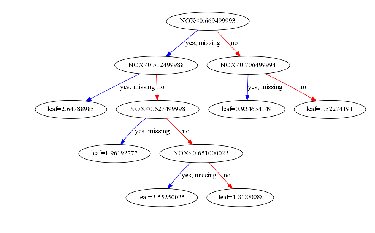

In [35]:
xgb.plot_tree(xg_reg, num_trees=0)
plt.rcParams['figure.figsize'] = [50,10]
plt.show()

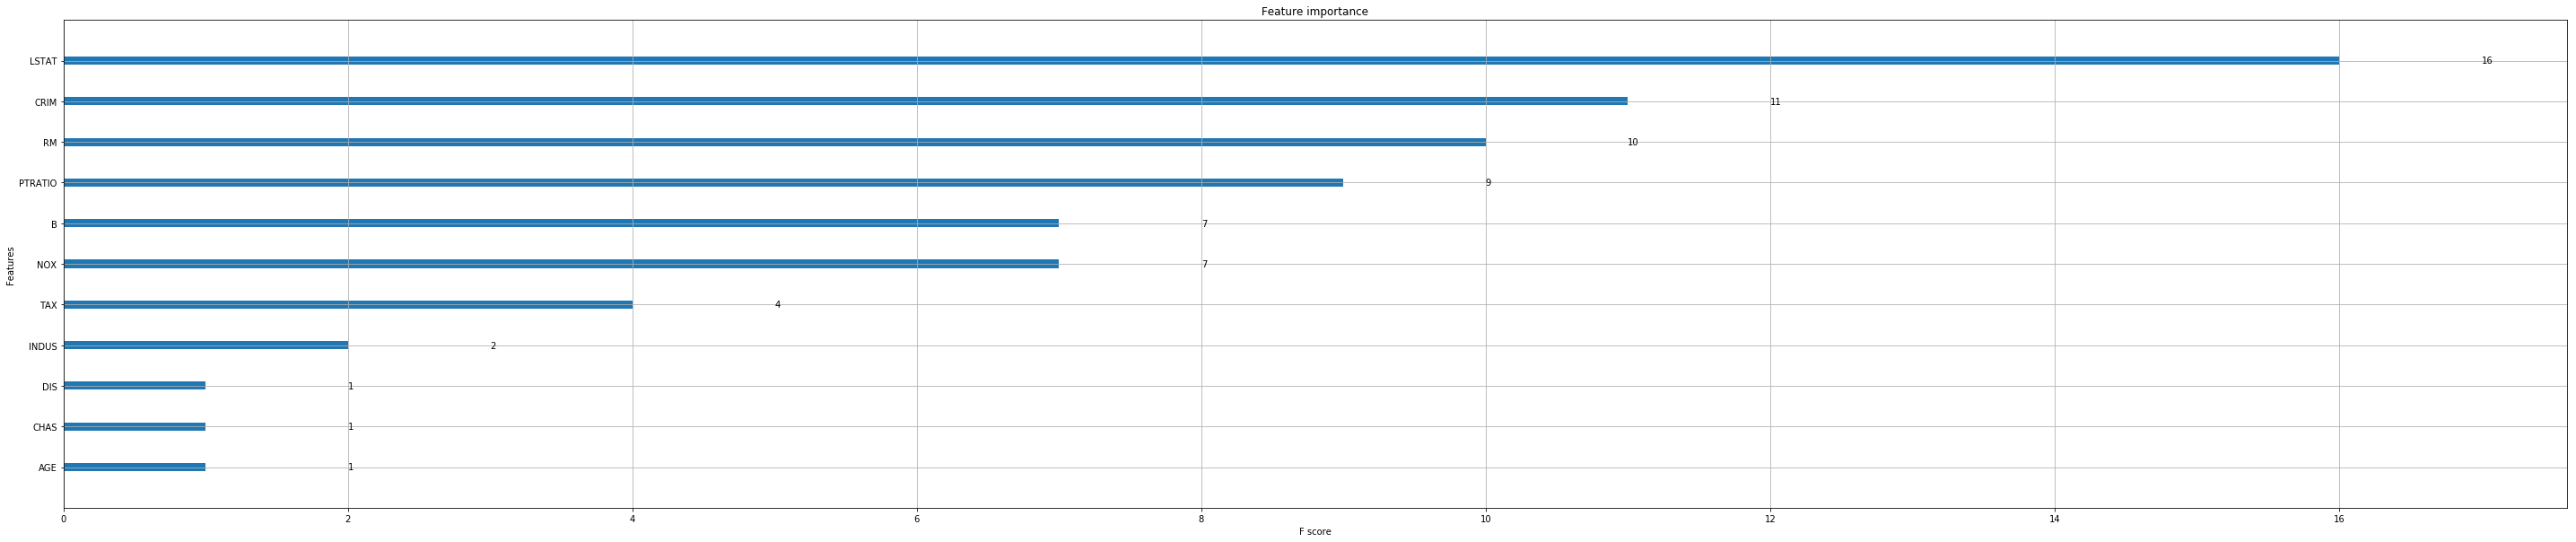

In [36]:
###########################
######### XGBoost #########
###########################

xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5,5]
plt.show()

#### LGBM

We need to convert our training data into LightGBM dataset format(this is mandatory for LightGBM training).

After creating a converting dataset, I created a python dictionary with parameters and their values. Accuracy of your model totally depends on the values you provide to parameters.

In [37]:
# Importing the dataset
dataset = pd.read_csv('Social_Network_Ads.csv')
X = dataset.iloc[:, [2, 3]].values
y = dataset.iloc[:, 4].values
# Splitting the dataset into the Training set and Test set

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)


sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

d_train = lgb.Dataset(x_train, label=y_train)
params = {}
params['learning_rate'] = 0.003
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['num_leaves'] = 10
params['min_data'] = 50
params['max_depth'] = 10
clf = lgb.train(params, d_train, 100)

In [38]:
params

{'learning_rate': 0.003,
 'boosting_type': 'gbdt',
 'objective': 'binary',
 'metric': 'binary_logloss',
 'sub_feature': 0.5,
 'num_leaves': 10,
 'min_data': 50,
 'max_depth': 10}

In [39]:
#Prediction
y_pred=clf.predict(x_test)

#convert into binary values
for i in range(0,100):
    if y_pred[i]>=.5:       # setting threshold to .5
       y_pred[i]=1
    else:  
       y_pred[i]=0

In [40]:
y_pred

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [41]:
cm = confusion_matrix(y_test, y_pred)
accuracy=accuracy_score(y_pred,y_test)
print(cm)
print(accuracy)

[[68  0]
 [32  0]]
0.68


**For better accuracy:**<br>
Use large `max_bin` (may be slower)<br>
Use small `learning_rate` with large num_iterations<br>
Use large `num_leaves`(may cause over-fitting)<br>
Use bigger `training data`<br>
Try `dart`<br>
Try to use `categorical feature` directly<br>

**To deal with over-fitting:**<br>
Use small `max_bin`<br>
Use small `num_leaves`<br>
Use `min_data_in_leaf` and `min_sum_hessian_in_leaf`<br>
Use bagging by set `bagging_fraction` and `bagging_freq`<br>
Use feature `sub-sampling` by set `feature_fraction`<br>
Use bigger `training data`<br>
Try `lambda_l1`, `lambda_l2` and `min_gain_to_split` to `regularization`<br>
Try `max_depth` to avoid growing deep tree

<a id="t4.0"></a>
## Stacking
#### The intuition behind stacking

- Know the team: Strengths and weaknesses
- Define tasks: responsibilities
- Take part: participation

Stacking is an ensemble learning technique to combine multiple classification models via a meta-classifier. The individual classification models are trained based on the complete training set; then, the meta-classifier is fitted based on the outputs -- meta-features -- of the individual classification models in the ensemble. The meta-classifier can either be trained on the predicted class labels or probabilities from the ensemble.

<img src="Stacking.JPG">

In [42]:
mushrooms = pd.read_csv('mushrooms.csv')

In [43]:
mushrooms.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [44]:
X = mushrooms.loc[:, mushrooms.columns != 'class']
y = mushrooms.loc[:, mushrooms.columns == 'class']

Type_mapping = {
    'e':0,
    'p':1
}

y['class'] = y['class'].map(Type_mapping)
X = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [45]:
# Instantiate a Naive Bayes classifier
clf_nb = GaussianNB()

# Fit the model to the training set
clf_nb.fit(X_train, y_train)

# Calculate the predictions on the test set
pred = clf_nb.predict(X_test)

# Evaluate the performance using the accuracy score
print("Accuracy: {:0.4f}".format(accuracy_score(y_test, pred)))

Accuracy: 0.9660


In [46]:
# Instantiate a 5-nearest neighbors classifier with 'ball_tree' algorithm
clf_knn = KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree')

# Fit the model to the training set
clf_knn.fit(X_train, y_train)

# Calculate the predictions on the test set
pred = clf_knn.predict(X_test)

# Evaluate the performance using the accuracy score
print("Accuracy: {:0.4f}".format(accuracy_score(y_test, pred)))

Accuracy: 1.0000


#### Time to build first stacking model

In [47]:
ratings = pd.read_csv('googleplaystore.CSV')
features = ['Reviews', 'Size', 'Installs', 'Type', 'Price', 'Content Rating']
ratings.dropna(inplace = True)
X = ratings[features]
y = ratings.loc[:, ratings.columns == 'Rating']

def value_to_float(x):
    if type(x) == float or type(x) == int:
        return x
    if 'K' in x:
        if len(x) > 1:
            return float(x.replace('K', '')) * 1000
        return 1000.0
    if 'M' in x:
        if len(x) > 1:
            return float(x.replace('M', '')) * 1000000
        return 1000000.0
    if 'B' in x:
        return float(x.replace('B', '')) * 1000000000
    return 0.0

X['Size'] = X.loc[:,'Size'].apply(value_to_float)
X['Installs'] = X['Installs'].map(lambda x: re.sub(r'[\,\+]','',x)).astype('float64')
X['Price'] = X['Price'].map(lambda x: re.sub(r'[\$]','',x)).astype('float64')
X['Reviews']= X.Reviews.astype('int64')
y['Rating']= y.Rating.astype('int64')
Type_mapping = {
    'Free':0,
    'Paid':1
}

Content_mapping = {
    'Everyone':0,
    'Teen':13,
    'Mature 17+':17,
    'Everyone 10+':10,
    'Adults only 18+':18,
    'Unrated':1
}
X['Type'] = X['Type'].map(Type_mapping)
X['Content Rating'] = X['Content Rating'].map(Content_mapping)


# Split into train (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)


In [48]:
# Build and fit a Decision Tree classifier
clf_dt = DecisionTreeClassifier(min_samples_leaf=3, min_samples_split=9, random_state=500)
clf_dt.fit(X_train, y_train)

# Build and fit a 5-nearest neighbors classifier using the 'Ball-Tree' algorithm
clf_knn = KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree')
clf_knn.fit(X_train, y_train)

# Evaluate the performance using the accuracy score
print('Decision Tree: {:0.4f}'.format(accuracy_score(y_test, clf_dt.predict(X_test))))
print('5-Nearest Neighbors: {:0.4f}'.format(accuracy_score(y_test, clf_knn.predict(X_test))))

Decision Tree: 0.7126
5-Nearest Neighbors: 0.7137


#### Building the second-layer classifier

In [49]:
# Create a Pandas DataFrame with the predictions
pred_df = pd.DataFrame({
    'pred_dt':clf_dt.predict(X_train),
    'pred_knn':clf_knn.predict(X_train)
}, index=X_train.index)

# Concatenate X_train with the predictions DataFrame
X_train_2nd = pd.concat([X_train, pred_df], axis=1)

# Build the second-layer meta estimator
clf_stack = DecisionTreeClassifier(random_state=500)
clf_stack.fit(X_train_2nd, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=500, splitter='best')

In [50]:
pred_dt = clf_dt.predict(X_test)
pred_knn = clf_knn.predict(X_test)

# Create a Pandas DataFrame with the predictions
pred_df = pd.DataFrame({
	'pred_dt': pred_dt,
    'pred_knn': pred_knn
}, index=X_test.index)

# Concatenate X_test with the predictions DataFrame
X_test_2nd = pd.concat([X_test, pred_df], axis=1)

# Obtain the final predictions from the second-layer estimator
pred_stack = clf_stack.predict(X_test_2nd)

# Evaluate the new performance on the test set
print('Accuracy: {:0.4f}'.format(accuracy_score(y_test, pred_stack)))

Accuracy: 0.7067


### mlxtend
Characteristics:
- Individual estimators are trained on the complete features
- The meta-estimator is trained using the predictions as the only meta-features
- The meta-estimator can be trained with labels or probabilities as target

In [51]:
# Instantiate the first-layer classifiers
clf_dt = DecisionTreeClassifier(min_samples_leaf=3, min_samples_split=9, random_state=500)
clf_knn = KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree')

# Instantiate the second-layer meta classifier
clf_meta = DecisionTreeClassifier(random_state=500)

# Build the Stacking classifier
clf_stack = StackingClassifier([clf_dt,clf_knn], meta_classifier=clf_meta, use_features_in_secondary=True)
clf_stack.fit(X_train, y_train)

# Evaluate the performance of the Stacking classifier
pred_stack = clf_stack.predict(X_test)
print("Accuracy: {:0.4f}".format(accuracy_score(y_test, pred_stack)))

Accuracy: 0.7067


#### Back to regression with stacking

In [52]:
# Instantiate the 1st-layer regressors
reg_dt = DecisionTreeRegressor(min_samples_leaf=11, min_samples_split=33, random_state=500)
reg_lr = LinearRegression(normalize=True)
reg_ridge = Ridge(random_state=500)

# Instantiate the 2nd-layer regressor
reg_meta = LinearRegression()

# Build the Stacking regressor
reg_stack = StackingRegressor([reg_dt, reg_lr, reg_ridge], meta_regressor=reg_meta)
reg_stack.fit(X_train, y_train)

# Evaluate the performance on the test set using the MAE metric
pred = reg_stack.predict(X_test)
print('MAE: {:.3f}'.format(mean_absolute_error(y_test, pred)))

MAE: 0.354


#### Back to Mushrooms dataset for classification

In [53]:
X = mushrooms.loc[:, mushrooms.columns != 'class']
y = mushrooms.loc[:, mushrooms.columns == 'class']

Type_mapping = {
    'e':0,
    'p':1
}

y['class'] = y['class'].map(Type_mapping)
X = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [54]:
# Create the first-layer models
clf_knn = KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree')
clf_dt = DecisionTreeClassifier(min_samples_leaf=5, min_samples_split=15, random_state=500)
clf_nb = GaussianNB()

# Create the second-layer model (meta-model)
clf_lr = LogisticRegression()

# Create and fit the stacked model
clf_stack = StackingClassifier([clf_knn, clf_dt, clf_nb], meta_classifier=clf_lr)
clf_stack.fit(X_train, y_train)

# Evaluate the stacked model’s performance
print("Accuracy: {:0.4f}".format(accuracy_score(y_test, clf_stack.predict(X_test))))

Accuracy: 1.0000


**Another example**

In [62]:
iris = datasets.load_iris()
X, y = iris.data[:, 1:3], iris.target

clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], 
                          meta_classifier=lr)

print('3-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, sclf], 
                      ['KNN', 
                       'Random Forest', 
                       'Naive Bayes',
                       'StackingClassifier']):

    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

3-fold cross validation:

Accuracy: 0.91 (+/- 0.01) [KNN]
Accuracy: 0.95 (+/- 0.01) [Random Forest]
Accuracy: 0.91 (+/- 0.02) [Naive Bayes]
Accuracy: 0.95 (+/- 0.02) [StackingClassifier]


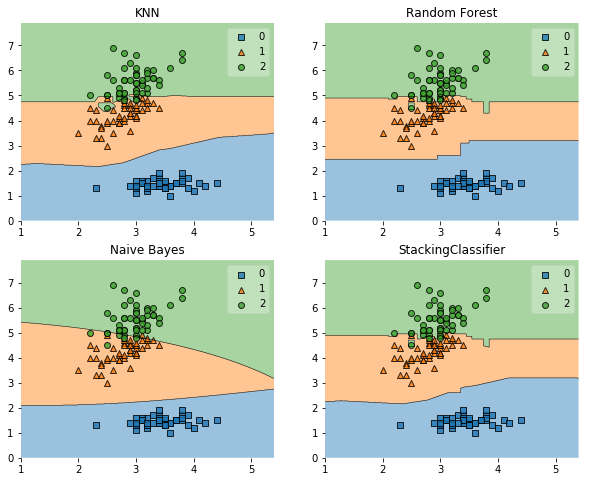

In [64]:
gs = gridspec.GridSpec(2,2)
fig = plt.figure(figsize=(10,8))

for clf, lab, grd in zip([clf1, clf2, clf3, sclf], 
                         ['KNN', 
                          'Random Forest', 
                          'Naive Bayes',
                          'StackingClassifier'],
                          itertools.product([0, 1], repeat=2)):

    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf)
    plt.title(lab)

#### Stacked Classification & GridSearch

In [67]:
clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], 
                          meta_classifier=lr)

params = {'kneighborsclassifier__n_neighbors': [1, 5],
          'randomforestclassifier__n_estimators': [10, 50],
          'meta_classifier__C': [0.1, 10.0]}

grid = GridSearchCV(estimator=sclf, 
                    param_grid=params, 
                    cv=5,
                    refit=True)
grid.fit(X, y)

cv_keys = ('mean_test_score', 'std_test_score', 'params')

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_[cv_keys[0]][r],
             grid.cv_results_[cv_keys[1]][r] / 2.0,
             grid.cv_results_[cv_keys[2]][r]))

print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)

0.933 +/- 0.03 {'kneighborsclassifier__n_neighbors': 1, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 10}
0.940 +/- 0.02 {'kneighborsclassifier__n_neighbors': 1, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 50}
0.927 +/- 0.03 {'kneighborsclassifier__n_neighbors': 1, 'meta_classifier__C': 10.0, 'randomforestclassifier__n_estimators': 10}
0.947 +/- 0.02 {'kneighborsclassifier__n_neighbors': 1, 'meta_classifier__C': 10.0, 'randomforestclassifier__n_estimators': 50}
0.947 +/- 0.02 {'kneighborsclassifier__n_neighbors': 5, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 10}
0.947 +/- 0.02 {'kneighborsclassifier__n_neighbors': 5, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 50}
0.933 +/- 0.02 {'kneighborsclassifier__n_neighbors': 5, 'meta_classifier__C': 10.0, 'randomforestclassifier__n_estimators': 10}
0.940 +/- 0.02 {'kneighborsclassifier__n_neighbors': 5, 'meta_classifier__C': 10.0, 'randomforestclassifier_

#### Stacking on Classifiers that operate on different feature subsets

In [72]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

pipe1 = make_pipeline(ColumnSelector(cols=(0, 2)),
                      LogisticRegression())
pipe2 = make_pipeline(ColumnSelector(cols=(1, 2, 3)),
                      LogisticRegression())

sclf = StackingClassifier(classifiers=[pipe1, pipe2], 
                          meta_classifier=LogisticRegression())

sclf.fit(X, y)

StackingClassifier(average_probas=False,
                   classifiers=[Pipeline(memory=None,
                                         steps=[('columnselector',
                                                 ColumnSelector(cols=(0, 2),
                                                                drop_axis=False)),
                                                ('logisticregression',
                                                 LogisticRegression(C=1.0,
                                                                    class_weight=None,
                                                                    dual=False,
                                                                    fit_intercept=True,
                                                                    intercept_scaling=1,
                                                                    l1_ratio=None,
                                                                    max_iter=100,
                       

#### ROC Curve with decision_function

In [74]:
iris = datasets.load_iris()
X, y = iris.data[:, [0, 1]], iris.target

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

RANDOM_SEED = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=RANDOM_SEED)

clf1 =  LogisticRegression()
clf2 = RandomForestClassifier(random_state=RANDOM_SEED)
clf3 = SVC(random_state=RANDOM_SEED)
lr = LogisticRegression()

sclf = StackingClassifier(classifiers=[clf1, clf2, clf3],
                          meta_classifier=lr)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(sclf)

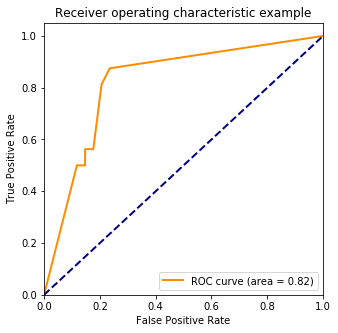

In [75]:
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

**Using `decision_function()`**

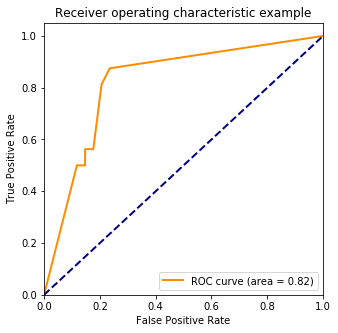

In [76]:
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()